In [1]:
!pip install duckdb==1.2.2
import duckdb


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
!curl https://certs.secureserver.net/repository/sf-class2-root.crt -O
%pip install cassandra-sigv4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1468  100  1468    0     0      0      0 --:--:-- --:--:-- --:--:--     0    0   7066      0 --:--:-- --:--:-- --:--:--  7160
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Part 1

In [3]:
# establish connection
conn = duckdb.connect('mimic.db', read_only=False)

conn.sql('SHOW TABLES;')

┌───────────────┐
│     name      │
│    varchar    │
├───────────────┤
│ ADMISSIONS    │
│ DRGCODES      │
│ D_ICDPROCS    │
│ ICUSTAYS      │
│ PATIENTS      │
│ PRESCRIPTIONS │
│ PROCS_ICD     │
└───────────────┘

In [4]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS PRESCRIPTIONS AS
    SELECT * FROM read_csv_auto('PRESCRIPTIONS.csv');
""")

## Part 1 - 1


In [253]:
df_top_drugtype_by_ethnicity = conn.execute("""
SELECT
    ETHNICITY AS ETHNICITY,
    DRUG AS DRUG,
    AMOUNT
FROM (
    SELECT
        ADMISSIONS.ETHNICITY,
        PRESCRIPTIONS.DRUG,
        COUNT(*) AS AMOUNT
    FROM PRESCRIPTIONS
    JOIN ADMISSIONS ON PRESCRIPTIONS.HADM_ID = ADMISSIONS.HADM_ID
    GROUP BY ADMISSIONS.ETHNICITY, PRESCRIPTIONS.DRUG
) AS counts
QUALIFY AMOUNT = MAX(AMOUNT) OVER (PARTITION BY ETHNICITY)
ORDER BY ETHNICITY;
""").fetchdf()

df_top_drugtype_by_ethnicity

,ETHNICITY,DRUG,AMOUNT
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,27
1,ASIAN,D5W,27
2,BLACK/AFRICAN AMERICAN,Insulin,38
3,HISPANIC OR LATINO,5% Dextrose,28
4,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,86
5,OTHER,NS,11
6,UNABLE TO OBTAIN,0.9% Sodium Chloride,28
7,UNKNOWN/NOT SPECIFIED,D5W,37
8,WHITE,Potassium Chloride,381


## Part 1 - 2


In [188]:
df_procs_19 = conn.execute("""
    SELECT D_ICDPROCS.LONG_TITLE AS PROCEDURE_NAME, COUNT(*) AS COUNT
    FROM PROCS_ICD
    JOIN ADMISSIONS ON PROCS_ICD.HADM_ID = ADMISSIONS.HADM_ID
    JOIN PATIENTS ON PROCS_ICD.SUBJECT_ID = PATIENTS.SUBJECT_ID
    JOIN D_ICDPROCS ON PROCS_ICD.ICD9_CODE = D_ICDPROCS.ICD9_CODE
    WHERE FLOOR(DATE_DIFF('year', CAST(PATIENTS.DOB AS TIMESTAMP), CAST(ADMISSIONS.ADMITTIME AS TIMESTAMP))) <= 19
    GROUP BY PROCEDURE_NAME
    ORDER BY COUNT DESC
    LIMIT 3;
""").fetchdf()

df_procs_19


,PROCEDURE_NAME,COUNT
0,"Venous catheterization, not elsewhere classified",2
1,Interruption of the vena cava,1
2,Fusion or refusion of 2-3 vertebrae,1


In [10]:
df_procs_20_49 = conn.execute("""
    SELECT D_ICDPROCS.LONG_TITLE AS PROCEDURE_NAME, COUNT(*) AS COUNT
    FROM PROCS_ICD
    JOIN ADMISSIONS ON PROCS_ICD.HADM_ID = ADMISSIONS.HADM_ID
    JOIN PATIENTS ON PROCS_ICD.SUBJECT_ID = PATIENTS.SUBJECT_ID
    JOIN D_ICDPROCS ON PROCS_ICD.ICD9_CODE = D_ICDPROCS.ICD9_CODE
    WHERE FLOOR(DATE_DIFF('year', CAST(PATIENTS.DOB AS TIMESTAMP), CAST(ADMISSIONS.ADMITTIME AS TIMESTAMP))) BETWEEN 20 AND 49
    GROUP BY PROCEDURE_NAME
    ORDER BY COUNT DESC
    LIMIT 3;
""").fetchdf()

df_procs_20_49


,PROCEDURE_NAME,COUNT
0,"Venous catheterization, not elsewhere classified",9
1,Enteral infusion of concentrated nutritional s...,7
2,Percutaneous abdominal drainage,6


In [11]:
df_procs_50_79 = conn.execute("""
    SELECT D_ICDPROCS.LONG_TITLE AS PROCEDURE_NAME, COUNT(*) AS COUNT
    FROM PROCS_ICD
    JOIN ADMISSIONS ON PROCS_ICD.HADM_ID = ADMISSIONS.HADM_ID
    JOIN PATIENTS ON PROCS_ICD.SUBJECT_ID = PATIENTS.SUBJECT_ID
    JOIN D_ICDPROCS ON PROCS_ICD.ICD9_CODE = D_ICDPROCS.ICD9_CODE
    WHERE FLOOR(DATE_DIFF('year', CAST(PATIENTS.DOB AS TIMESTAMP), CAST(ADMISSIONS.ADMITTIME AS TIMESTAMP))) BETWEEN 50 AND 79
    GROUP BY PROCEDURE_NAME
    ORDER BY COUNT DESC
    LIMIT 3;
""").fetchdf()

df_procs_50_79


,PROCEDURE_NAME,COUNT
0,"Venous catheterization, not elsewhere classified",25
1,Enteral infusion of concentrated nutritional s...,22
2,Transfusion of packed cells,13


In [12]:
df_procs_80plus = conn.execute("""
    SELECT D_ICDPROCS.LONG_TITLE AS PROCEDURE_NAME, COUNT(*) AS COUNT
    FROM PROCS_ICD
    JOIN ADMISSIONS ON PROCS_ICD.HADM_ID = ADMISSIONS.HADM_ID
    JOIN PATIENTS ON PROCS_ICD.SUBJECT_ID = PATIENTS.SUBJECT_ID
    JOIN D_ICDPROCS ON PROCS_ICD.ICD9_CODE = D_ICDPROCS.ICD9_CODE
    WHERE FLOOR(DATE_DIFF('year', CAST(PATIENTS.DOB AS TIMESTAMP), CAST(ADMISSIONS.ADMITTIME AS TIMESTAMP))) >= 80
    GROUP BY PROCEDURE_NAME
    ORDER BY COUNT DESC
    LIMIT 3;
""").fetchdf()

df_procs_80plus


,PROCEDURE_NAME,COUNT
0,"Venous catheterization, not elsewhere classified",20
1,Transfusion of packed cells,13
2,Insertion of endotracheal tube,8


## Part 1 - 3


In [13]:
df_icu_overall = conn.execute("""
    SELECT
        ROUND(AVG(
            DATE_DIFF('minute',
                CAST(ICUSTAYS.INTIME AS TIMESTAMP),
                CAST(ICUSTAYS.OUTTIME AS TIMESTAMP)
            ) / 60.0
        ), 2) AS AVG_ICU_HOURS
    FROM ICUSTAYS
    WHERE INTIME IS NOT NULL AND OUTTIME IS NOT NULL;
""").fetchdf()

df_icu_overall


,AVG_ICU_HOURS
0,106.86


In [129]:
df_icu_by_gender = conn.execute("""
    SELECT
        PATIENTS.GENDER,
        ROUND(AVG(
            DATE_DIFF('minute',
                CAST(ICUSTAYS.INTIME AS TIMESTAMP),
                CAST(ICUSTAYS.OUTTIME AS TIMESTAMP)
            ) / 60.0
        ), 0) AS AVG_ICU_HOURS
    FROM ICUSTAYS
    JOIN PATIENTS ON ICUSTAYS.SUBJECT_ID = PATIENTS.SUBJECT_ID
    WHERE INTIME IS NOT NULL AND OUTTIME IS NOT NULL
    GROUP BY PATIENTS.GENDER;
""").fetchdf()

df_icu_by_gender

,gender,AVG_ICU_HOURS
0,F,133.0
1,M,84.0


In [128]:
df_icu_by_ethnicity = conn.execute("""
    SELECT
        ADMISSIONS.ETHNICITY,
        ROUND(AVG(
            DATE_DIFF('minute',
                CAST(ICUSTAYS.INTIME AS TIMESTAMP),
                CAST(ICUSTAYS.OUTTIME AS TIMESTAMP)
            ) / 60.0
        ), 0) AS AVG_ICU_HOURS
    FROM ICUSTAYS
    JOIN ADMISSIONS ON ICUSTAYS.HADM_ID = ADMISSIONS.HADM_ID
    WHERE INTIME IS NOT NULL AND OUTTIME IS NOT NULL
    GROUP BY ADMISSIONS.ETHNICITY
    ORDER BY AVG_ICU_HOURS DESC;

""").fetchdf()

df_icu_by_ethnicity

,ethnicity,AVG_ICU_HOURS
0,UNABLE TO OBTAIN,321.0
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,272.0
2,BLACK/AFRICAN AMERICAN,184.0
3,HISPANIC OR LATINO,179.0
4,UNKNOWN/NOT SPECIFIED,118.0
5,WHITE,99.0
6,ASIAN,93.0
7,HISPANIC/LATINO - PUERTO RICAN,78.0
8,OTHER,22.0


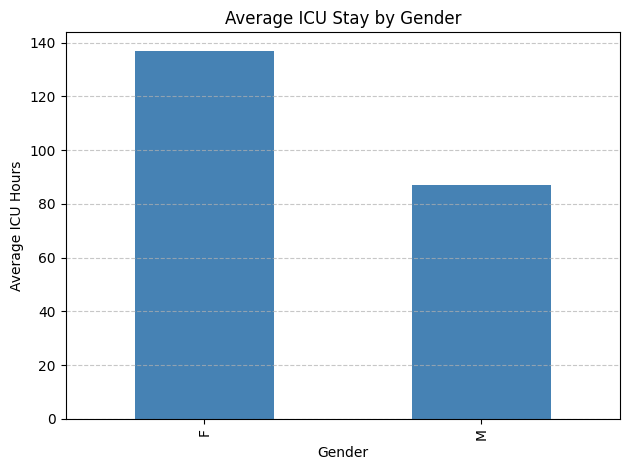

In [149]:
import matplotlib.pyplot as plt

# Assuming df_icu_by_gender is already defined
df_icu_by_gender.plot(kind="bar", x="gender", y="AVG_ICU_HOURS", color="steelblue", legend=False)
plt.title("Average ICU Stay by Gender")
plt.ylabel("Average ICU Hours")
plt.xlabel("Gender")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


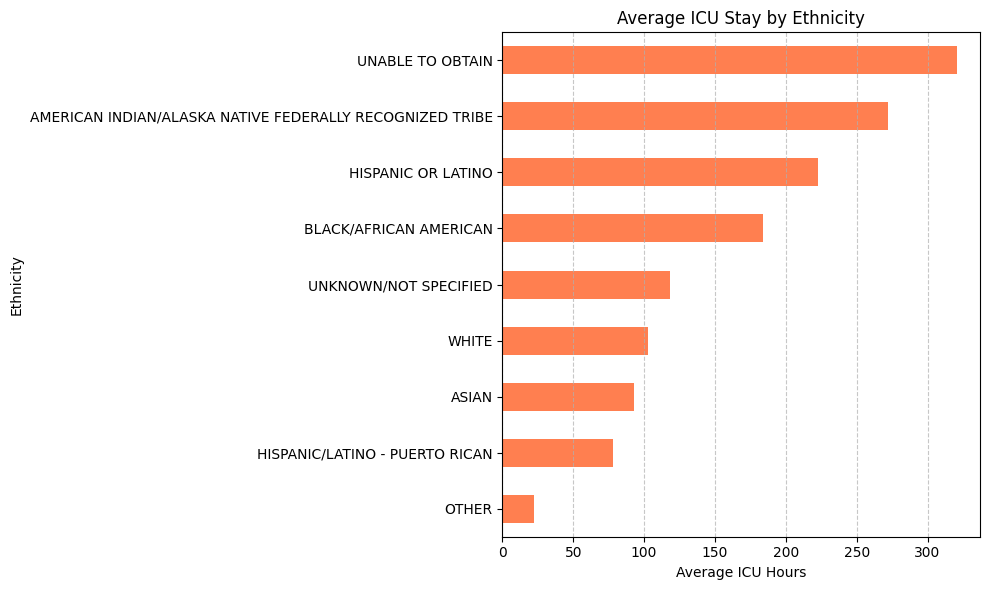

In [150]:
# Assuming df_icu_by_ethnicity is already defined
df_icu_by_ethnicity_sorted = df_icu_by_ethnicity.sort_values("AVG_ICU_HOURS", ascending=True)

df_icu_by_ethnicity_sorted.plot(kind="barh", x="ethnicity", y="AVG_ICU_HOURS", color="coral", legend=False, figsize=(10,6))
plt.title("Average ICU Stay by Ethnicity")
plt.xlabel("Average ICU Hours")
plt.ylabel("Ethnicity")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Part 2

No copies of the AWS crendentials file is stored on any publicly accessible location, nor is the file in any way shared with anyone outside of DATA_ENG 300 (Spring 2025).

In [153]:
from cassandra.cluster import Cluster
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra_sigv4.auth import SigV4AuthProvider
import boto3

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations('sf-class2-root.crt')  # change your file path for locating the certificate
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

# authorization setup with SigV4
auth_provider = SigV4AuthProvider(boto_session)

#cluster setup 
cluster = Cluster(['cassandra.us-east-2.amazonaws.com'], 
                  ssl_context=ssl_context, 
                  auth_provider=auth_provider, 
                  port=9142)  # TLS only communicates on port 9142

session = cluster.connect()

# For example, create a keyspace for HW2
r = session.execute('''
    CREATE KEYSPACE IF NOT EXISTS de300_sabian_hw2_part2
    WITH replication = {'class': 'SingleRegionStrategy'};
    ''')
print(r.current_rows)

[]


In [159]:
from cassandra.cluster import ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel


# Define execution profile with LOCAL_QUORUM
execution_profile = ExecutionProfile(
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)

# Cluster setup with correct profile
cluster = Cluster(
    ['cassandra.us-east-2.amazonaws.com'],
    ssl_context=ssl_context,
    auth_provider=auth_provider,
    port=9142,
    execution_profiles={EXEC_PROFILE_DEFAULT: execution_profile}
)

# establishing connection to Keyspace
session = cluster.connect()
session.set_keyspace('de300_sabian_hw2_part2')  # Replace with your keyspace ######

## Part 2-1

In [160]:
import pandas as pd

In [240]:
df_top_drugtype = conn.execute("""
    SELECT
        ADMISSIONS.ETHNICITY,
        PRESCRIPTIONS.DRUG,
        PRESCRIPTIONS.Row_id AS PRE_ID,
        ADMISSIONS.row_id as ADM_ID
    FROM ADMISSIONS
    LEFT JOIN PRESCRIPTIONS
        ON PRESCRIPTIONS.HADM_ID = ADMISSIONS.HADM_ID
    WHERE PRE_ID IS NOT NULL
    AND ADM_ID IS NOT NULL
""").fetchdf()

df_top_drugtype

,ethnicity,drug,PRE_ID,ADM_ID
0,WHITE,Pneumococcal Vac Polyvalent,32600,40565
1,WHITE,Bisacodyl,32601,40565
2,WHITE,Bisacodyl,32602,40565
3,WHITE,Senna,32603,40565
4,WHITE,Docusate Sodium (Liquid),32604,40565
...,...,...,...,...
10393,WHITE,Sodium Chloride 0.9% Flush,3609913,40554
10394,WHITE,Acetaminophen,3609914,40554
10395,WHITE,0.9% Sodium Chloride,3609915,40554
10396,WHITE,D5W,3609916,40554


In [248]:
session.set_keyspace('de300_sabian_hw2_part2') 

session.execute("""
CREATE TABLE IF NOT EXISTS drug_ethnicity_hadm_3 (
    PRE_ID INT,
    ADM_ID INT,
    Ethnicity TEXT,
    Drug text,
    PRIMARY KEY ((ethnicity), PRE_ID, ADM_ID)
);
""")


In [249]:
session.set_keyspace('de300_sabian_hw2_part2') 

insert_adm = session.prepare("""
    INSERT INTO drug_ethnicity_hadm_3 (PRE_ID, ADM_ID, Ethnicity, Drug)
    VALUES (?, ?, ?, ?)
""")

for _, row in df_top_drugtype.iterrows():
    session.execute(insert_adm, (
        int(row['PRE_ID']),
        int(row['ADM_ID']),
        str(row['ethnicity']),
        str(row['drug'])
    ))

In [252]:
rows = session.execute("SELECT ethnicity FROM drug_ethnicity_hadm_3")
ethnicity_list = list(set(row.ethnicity for row in rows))

records = []

for eth in ethnicity_list:
    rows = session.execute("""
        SELECT drug FROM drug_ethnicity_hadm_3 WHERE ethnicity = %s
    """, [eth])
    
    # Convert rows to DataFrame
    df_eth = pd.DataFrame(rows)
    

    # Group by drug and count
    df_grouped = (
        df_eth.groupby('drug')
        .size()
        .reset_index(name='amount')
        .sort_values('amount', ascending=False)
    )
    
    # Select top row (most frequent drug)
    top_row = df_grouped.iloc[0]
    records.append({
        'ETHNICITY': eth,
        'DRUG': top_row['drug'],
        'AMOUNT': top_row['amount']
    })

# Final result
df_top_drugs = pd.DataFrame(records)

df_top_drugs

,ETHNICITY,DRUG,AMOUNT
0,OTHER,NS,11
1,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,86
2,UNKNOWN/NOT SPECIFIED,D5W,37
3,UNABLE TO OBTAIN,0.9% Sodium Chloride,28
4,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,27
5,BLACK/AFRICAN AMERICAN,Insulin,38
6,HISPANIC OR LATINO,5% Dextrose,28
7,ASIAN,D5W,27
8,WHITE,Potassium Chloride,381


## Part 2-2

In [190]:
df_procs = conn.execute("""
    SELECT 
        D_ICDPROCS.LONG_TITLE AS PROCEDURE_NAME,
        FLOOR(DATE_DIFF('year', 
            CAST(PATIENTS.DOB AS TIMESTAMP), 
            CAST(ADMISSIONS.ADMITTIME AS TIMESTAMP)
        )) AS AGE,
        PROCS_ICD.row_id as PROCS_ID,
        ADMISSIONS.row_id as ADM_ID,
        PATIENTS.row_id as PAT_ID,
        D_ICDPROCS.row_id as D_ICD_ID
    FROM PROCS_ICD
    JOIN ADMISSIONS ON PROCS_ICD.HADM_ID = ADMISSIONS.HADM_ID
    JOIN PATIENTS ON PROCS_ICD.SUBJECT_ID = PATIENTS.SUBJECT_ID
    JOIN D_ICDPROCS ON PROCS_ICD.ICD9_CODE = D_ICDPROCS.ICD9_CODE;
""").fetchdf()

df_procs

,PROCEDURE_NAME,AGE,PROCS_ID,ADM_ID,PAT_ID,D_ICD_ID
0,Other operations on extraocular muscles and te...,53.0,14666,12296,9505,46
1,Transplant from cadaver,44.0,97642,12381,9581,110
2,Other diagnostic procedures on brain and cereb...,20.0,97148,12349,9553,125
3,Administration of inhaled nitric oxide,44.0,97636,12381,9581,143
4,Injection or infusion of nesiritide,44.0,97635,12381,9581,144
...,...,...,...,...,...,...
511,Transfusion of packed cells,86.0,51601,12324,9531,3846
512,Enteral infusion of concentrated nutritional s...,78.0,53157,12337,9544,3676
513,Transfusion of packed cells,70.0,47978,12353,9557,3846
514,Enteral infusion of concentrated nutritional s...,76.0,30867,12311,9519,3676


In [197]:
session.set_keyspace('de300_sabian_hw2_part2')
session.execute("""
CREATE TABLE IF NOT EXISTS procs (
    PROCEDURE_NAME TEXT,
    AGE INT,
    PROCS_ID INT,
    ADM_ID INT,
    PAT_ID INT,
    D_ICD_ID INT,
    PRIMARY KEY ((AGE), PROCS_ID,ADM_ID,PAT_ID,D_ICD_ID)
);
""")


In [198]:
insert_pat = session.prepare("""
    INSERT INTO procs (PROCEDURE_NAME, age, procs_id, adm_id, pat_id, d_icd_id)
    VALUES (?, ?, ?, ?,?,?)
""")

for _, row in df_procs.iterrows():
    session.execute(insert_pat, (
        str(row['PROCEDURE_NAME']),
        int(row['AGE']),
        int(row['PROCS_ID']),
        int(row['ADM_ID']),
        int(row['PAT_ID']),
        int(row['D_ICD_ID']),
    ))


In [200]:
rows = session.execute("SELECT procedure_name, age FROM procs")
df = pd.DataFrame(rows)

def age_group(age):
    if age <= 19:
        return "<=19"
    elif age <= 49:
        return "20-49"
    elif age <= 79:
        return "50-79"
    else:
        return "80+"

df['age_group'] = df['age'].apply(age_group)


df_grouped = (
    df.groupby(['procedure_name', 'age_group'])
    .size()
    .reset_index(name='count')
)


age_order = ['<=19', '20-49', '50-79', '80+']
df_top_procs['age_group'] = pd.Categorical(df_top_procs['age_group'], categories=age_order, ordered=True)
df_top_procs = df_top_procs.sort_values(['age_group', 'count'], ascending=[True, False]).reset_index(drop=True)

df_top_procs

,procedure_name,age_group,count
0,"Venous catheterization, not elsewhere classified",<=19,2
1,"Application of external fixator device, femur",<=19,1
2,Atlas-axis spinal fusion,<=19,1
3,"Venous catheterization, not elsewhere classified",20-49,9
4,Enteral infusion of concentrated nutritional s...,20-49,7
5,Continuous invasive mechanical ventilation for...,20-49,6
6,"Venous catheterization, not elsewhere classified",50-79,25
7,Enteral infusion of concentrated nutritional s...,50-79,22
8,Transfusion of packed cells,50-79,13
9,"Venous catheterization, not elsewhere classified",80+,20


## Part 2 - 3

In [208]:
icu_fuck = conn.execute("""
    SELECT
    ADMISSIONS.ETHNICITY,
    ROUND(
        DATE_DIFF('minute',
            CAST(ICUSTAYS.INTIME AS TIMESTAMP),
            CAST(ICUSTAYS.OUTTIME AS TIMESTAMP)
        ) / 60.0, 0
    ) AS ICU_HOURS,
    PATIENTS.GENDER,
    ICUSTAYS.row_id as ICU_ID,
    ADMISSIONS.row_id as adm_id,
    patients.row_id as pat_id
FROM ICUSTAYS
JOIN ADMISSIONS ON ICUSTAYS.HADM_ID = ADMISSIONS.HADM_ID
JOIN PATIENTS ON ICUSTAYS.SUBJECT_ID = PATIENTS.SUBJECT_ID
WHERE ICUSTAYS.INTIME IS NOT NULL AND ICUSTAYS.OUTTIME IS NOT NULL;

""").fetchdf()

icu_fuck

,ethnicity,ICU_HOURS,gender,ICU_ID,adm_id,pat_id
0,BLACK/AFRICAN AMERICAN,39.0,F,12742,12258,9467
1,UNKNOWN/NOT SPECIFIED,332.0,F,12747,12263,9472
2,UNKNOWN/NOT SPECIFIED,64.0,F,12749,12265,9474
3,WHITE,51.0,F,12754,12269,9478
4,WHITE,31.0,M,12755,12270,9479
...,...,...,...,...,...,...
131,HISPANIC/LATINO - PUERTO RICAN,50.0,M,41978,40400,31311
132,HISPANIC/LATINO - PUERTO RICAN,261.0,M,41977,40399,31311
133,HISPANIC/LATINO - PUERTO RICAN,259.0,M,41976,40398,31311
134,HISPANIC/LATINO - PUERTO RICAN,71.0,M,41975,40397,31311


In [217]:
##CREATE 2 PARTITIONS
session.set_keyspace('de300_sabian_hw2_part2')  # Replace with your keyspace ######
session.execute("""
CREATE TABLE IF NOT EXISTS icu_shit_GENDER (
    ETHNICITY TEXT,
    ICU_HOURS INT,
    GENDER TEXT,
    ICU_ID INT,
    ADM_ID INT,
    PAT_ID INT,
    PRIMARY KEY ((GENDER),ICU_ID,ADM_ID,PAT_ID)
);""")

session.execute("""
CREATE TABLE IF NOT EXISTS icu_shit_ETHNICITY (
    ETHNICITY TEXT,
    ICU_HOURS INT,
    GENDER TEXT,
    ICU_ID INT,
    ADM_ID INT,
    PAT_ID INT,
    PRIMARY KEY ((ETHNICITY),ICU_ID,ADM_ID,PAT_ID)
);""")


In [219]:

insert_query_gender = session.prepare("""
    INSERT INTO icu_shit_GENDER (ETHNICITY, ICU_HOURS, GENDER, ICU_ID,ADM_ID,PAT_ID)
    VALUES (?, ?, ?, ?, ?, ?)
""")

for _, row in icu_fuck.iterrows():
    session.execute(insert_query_gender, (
        str(row["ethnicity"]),
        int(row["ICU_HOURS"]),
        str(row["gender"]),
        int(row["ICU_ID"]),
        int(row["adm_id"]),
        int(row["pat_id"])
    ))

insert_query_ethnicity = session.prepare("""
    INSERT INTO icu_shit_ETHNICITY (ETHNICITY, ICU_HOURS, GENDER, ICU_ID,ADM_ID,PAT_ID)
    VALUES (?, ?, ?, ?, ?, ?)
""")

for _, row in icu_fuck.iterrows():
    session.execute(insert_query_ethnicity, (
        str(row["ethnicity"]),
        int(row["ICU_HOURS"]),
        str(row["gender"]),
        int(row["ICU_ID"]),
        int(row["adm_id"]),
        int(row["pat_id"])
    ))


In [220]:
rows = session.execute("SELECT ICU_HOURS FROM icu_shit_ETHNICITY")
df = pd.DataFrame(rows)
avg_icu = df["icu_hours"].mean()
print(f"Average ICU time (hours): {round(avg_icu, 2)}")

Average ICU time (hours): 106.89


In [223]:
genders = ["M","F"]

gender_stats = []

for gender in genders:
    rows = session.execute("SELECT ICU_HOURS FROM icu_shit_GENDER WHERE gender = %s", [gender])
    df_gender = pd.DataFrame(rows)
    if not df_gender.empty:
        avg = df_gender["icu_hours"].mean()
        gender_stats.append({"GENDER": gender, "AVG_ICU_HOURS": round(avg, 0)})

df_gender_avg = pd.DataFrame(gender_stats)
df_gender_avg

,GENDER,AVG_ICU_HOURS
0,M,84.0
1,F,133.0


In [225]:
ethnicities = icu_fuck["ethnicity"].unique()

ethnicity_stats = []

for eth in ethnicities:
    rows = session.execute("SELECT ICU_HOURS FROM icu_shit_ETHNICITY WHERE ethnicity = %s", [eth])
    df_eth = pd.DataFrame(rows)
    if not df_eth.empty:
        avg = df_eth["icu_hours"].mean()
        ethnicity_stats.append({"ETHNICITY": eth, "AVG_ICU_HOURS": round(avg, 2)})

df_ethnicity_avg = df_ethnicity_avg.sort_values(by="AVG_ICU_HOURS", ascending=False).reset_index(drop=True)
df_ethnicity_avg

,ETHNICITY,AVG_ICU_HOURS
0,UNABLE TO OBTAIN,321.00
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,272.00
2,BLACK/AFRICAN AMERICAN,184.14
3,HISPANIC OR LATINO,179.00
4,UNKNOWN/NOT SPECIFIED,118.27
5,WHITE,99.16
6,ASIAN,93.50
7,HISPANIC/LATINO - PUERTO RICAN,77.87
8,OTHER,22.33
